<a href="https://colab.research.google.com/github/PengKuang/wasp-assignmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Peng Kuang</font>

- **Team ID:** <font color='red'>LundBooster</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [4]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2025-07-30 15:12:55--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0 [following]
--2025-07-30 15:12:55--  https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4aed1c4b0024ff01a88121c37a.dl.dropboxusercontent.com/cd/0/inline/CudELaso1E8NftAex82IaHgRXewZ4Eo-BQH2wgaeFTfxfVu5X6PxbelIVP01HpfhiRQx-HRBe8h285X5yA-rfkIgvmTkEBL3LR9C4xE6lfbJ6FP6kgJanMlDGiL-gKn80TI/file# [following]
--2025-07-30 15:12:56--  https://uc4aed1c4b0024ff01a88121c37a.dl.dropboxusercontent.com/cd/0

In [5]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [6]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 386.28 KiB | 14.86 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

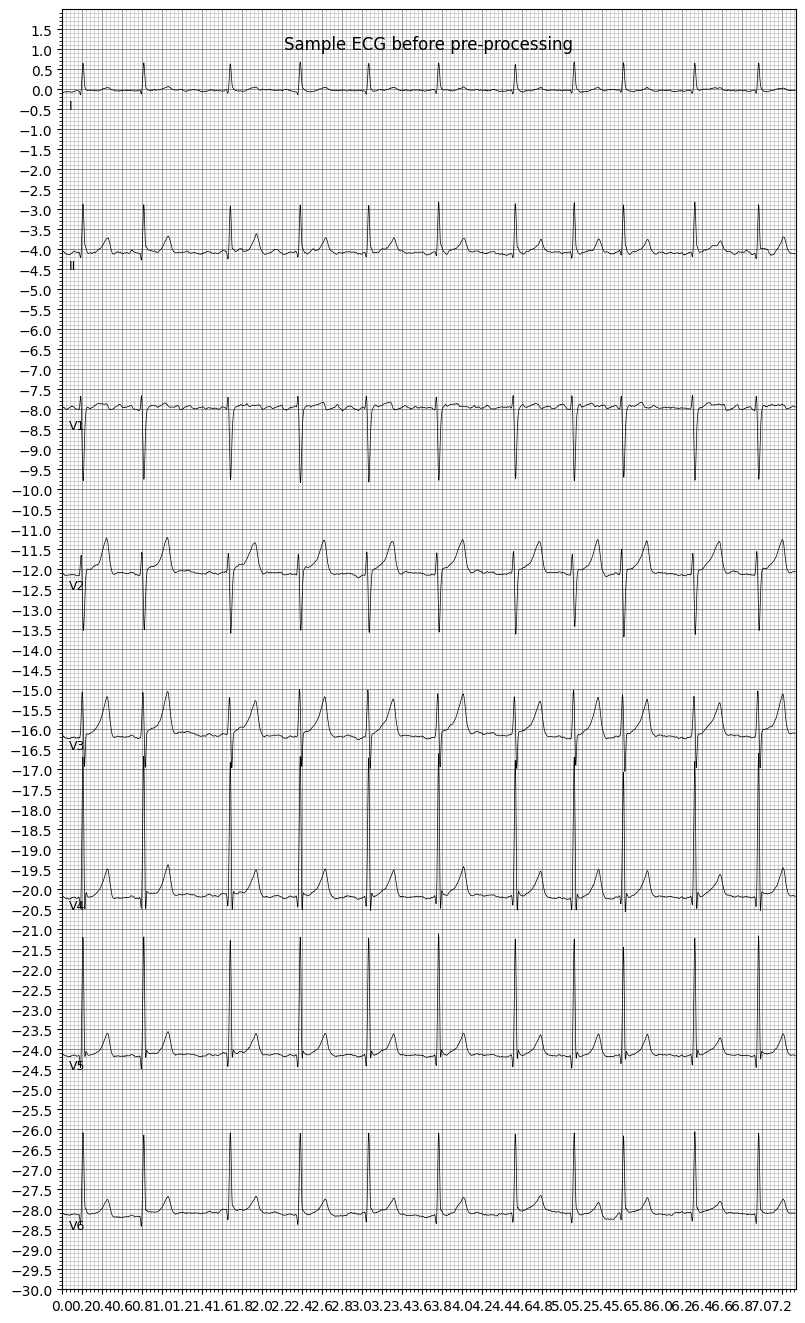

In [7]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

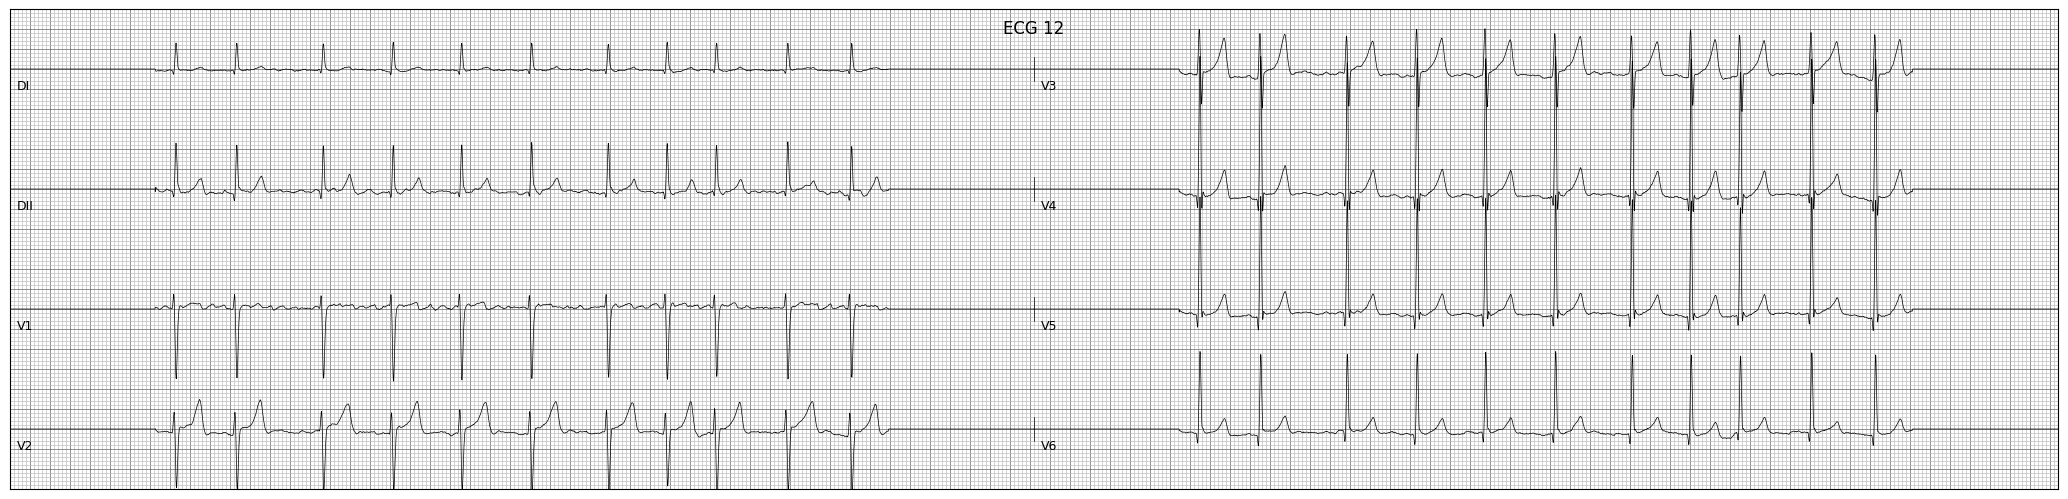

<Figure size 640x480 with 0 Axes>

In [8]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [9]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [01:14<00:00, 133.70it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:51<00:00, 116.13it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [10]:
"""
TASK: Insert your code here
"""

import h5py

PATH_TO_H5_FILE_TRAIN = 'codesubset/train.h5'
PATH_TO_H5_FILE_TEST = 'codesubset/test.h5'
f_train = h5py.File(PATH_TO_H5_FILE_TRAIN, 'r')
f_test = h5py.File(PATH_TO_H5_FILE_TEST, 'r')
data = f_train['tracings']

In [11]:
data.shape

(10000, 4096, 8)

In [12]:
data[1].shape

(4096, 8)

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

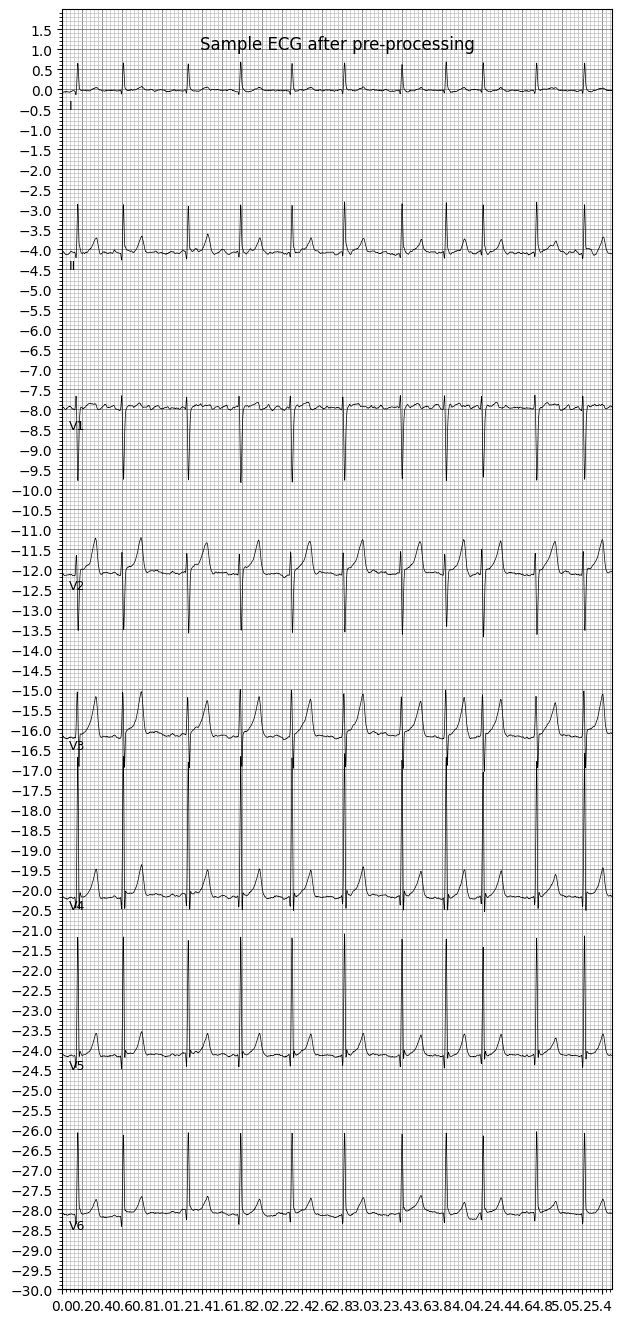

In [13]:
plt.figure()
# lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG after pre-processing')
plt.show()

In [14]:
import h5py
import pandas as pd
import numpy as np

path_to_csv_train_labels = 'codesubset/train.csv'
path_to_records = 'codesubset/train/RECORDS.txt'

# load labels and attributes from the CSV file
df = pd.read_csv(path_to_csv_train_labels)

# Get the order of ids in tracings from the RECORDS.txt file
with open(path_to_records, 'r') as r:
    ids_traces = [int(line.strip().split('TNMG')[1]) for line in r]

# Set 'id_exam' as the index and reindex the DataFrame to match the order of tracings
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces)

In [15]:
df.columns

Index(['id_patient', 'age', 'sex', 'AF', 'date_exam'], dtype='object')

In [16]:
# Access the labels (for Atrial Fibrillation - AF)
labels = np.array(df['AF'])

# Access age and sex
age = np.array(df['age'])
sex = np.array(df['sex'])

# You can now associate these labels and attributes with the corresponding tracings
# For example, to get the label, age, and sex for the first tracing (index 0):
first_tracing_label = labels[0]
first_tracing_age = age[0]
first_tracing_sex = sex[0]

print(f"Label for first tracing: {first_tracing_label}")
print(f"Age for first tracing: {first_tracing_age}")
print(f"Sex for first tracing: {first_tracing_sex}")

Label for first tracing: 1
Age for first tracing: 72
Sex for first tracing: F


In [17]:
# Distribution of patients in the train dataset
print("Distribution of Atrial Fibrillation (AF):")
print(df['AF'].value_counts())
print("\nPercentage distribution of AF:")
print(df['AF'].value_counts(normalize=True) * 100)

Distribution of Atrial Fibrillation (AF):
AF
0    7000
1    3000
Name: count, dtype: int64

Percentage distribution of AF:
AF
0    70.0
1    30.0
Name: proportion, dtype: float64



Descriptive statistics for Age:
count    10000.000000
mean        57.929600
std         17.921952
min         17.000000
25%         45.000000
50%         60.000000
75%         72.000000
max        103.000000
Name: age, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

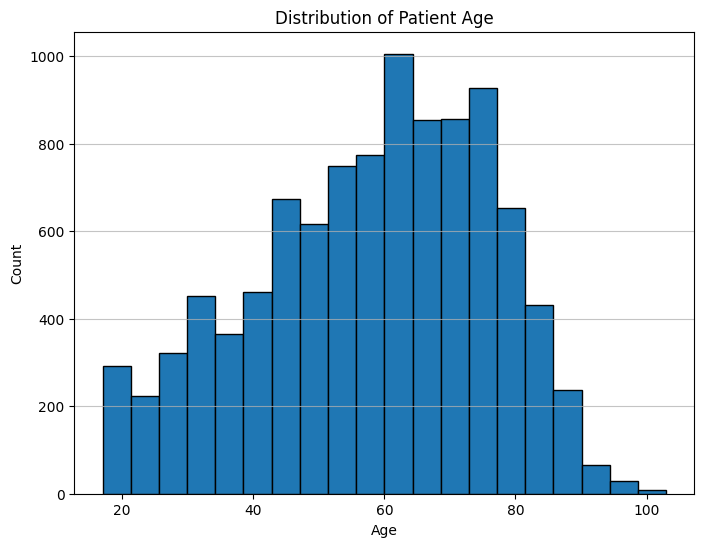

In [18]:
# 2. Examine the distribution of age
print("\nDescriptive statistics for Age:")
print(df['age'].describe())

plt.figure(figsize=(8, 6))
plt.hist(df['age'].dropna(), bins=20, edgecolor='black') # Drop NaN values for plotting
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()


Distribution of Sex:
sex
F    6307
M    3693
Name: count, dtype: int64

Percentage distribution of Sex:
sex
F    63.07
M    36.93
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

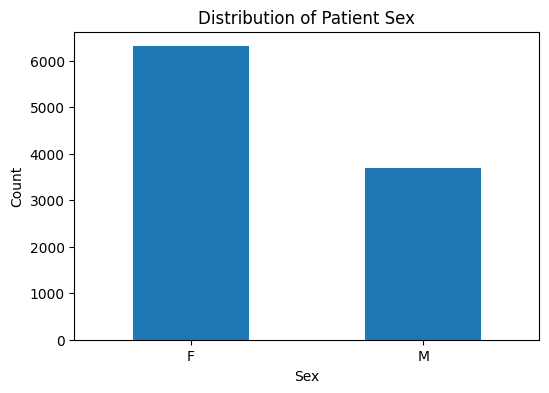

In [19]:
# 3. Examine the distribution of sex
print("\nDistribution of Sex:")
print(df['sex'].value_counts())
print("\nPercentage distribution of Sex:")
print(df['sex'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
df['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

The data is not very balanced since 30% of the samples are patients and 70% are healthy people. This is understandable since the scarcity of patient data is common in the field of healthcare. Actually, the absolute number of patient samples in this dataset is not small.

- Age:
  - The age ranges from 17 to 103 yo.
  - The mean age is 57.92 yo, with a standard deviation of 17.92.
  -  50% of are below 60 yo and 75% are below 72 yo.
- Sex: 60% of are female and 40% are male.

The preprocessing is necessary for several reasons:

1. Uniform sample rate makes sure the time intervals across different samples are the same.
2. Some neural netowrk models can only handle sequences with the same length.
2. Removing trends (e.g., baseline wander which is the flat parts of the leads) help preserve only meaningful data for the model to learn.
3. Removing power line noise enhance the data quality and the learning.



---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [20]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [21]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.kernel_size = 3

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn4 = nn.BatchNorm1d(256)


        # Max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)


        # Calculate the output size of the convolutional layers to determine the input size for the linear layer
        dummy_input = torch.randn(1, 8, 4096)
        x = self.conv1(dummy_input)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.bn3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.bn4(x)
        x = self.pool(x)

        flattened_size = x.view(x.size(0), -1).size(1)


        # Classification layer
        self.fc = nn.Linear(in_features=flattened_size, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = self.dropout3(x)

        x = self.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)
        output = self.fc(x)

        return output

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**
I chose the CNN model with multiple convolutional layers because it can better capture complex patterns and longer-term temperal tendancies.

The reason why I chose this autoencoder model is because it is effective at dealing with time series data such as ECG and EEG. I have used this model before for predicting patients and healthy individuals with other similar biometrics. In the essence, it handles an anomarly detection issue.


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [22]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        # Forward pass
        outputs = model(traces)
        # Calculate loss
        loss = loss_function(outputs, diagnoses)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [23]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            # Forward pass
            outputs = model(traces)
            # Calculate loss
            loss = loss_function(outputs, diagnoses)

            # Collect predictions and true labels
            valid_probs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**
- I have decreased the learning rate so to have a smoothier curve of gradient descedent to the local optimal
- I have increased the weight_decay to penalize overfitting so the trained model can generalize on new dataset better


In [24]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-4
weight_decay = 1e-1
num_epochs = 15
batch_size = 32

In [28]:
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data import WeightedRandomSampler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
train_size = int(0.8 * len_dataset)
valid_size = len_dataset - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])

# handle inbalanced classes: add sampler
train_labels_np = np.array([int(dataset_train[i][1].item()) for i in range(len(dataset_train))])
class_sample_counts = np.bincount(train_labels_np)
sample_weights = 1. / class_sample_counts
sample_weights = sample_weights[train_labels_np]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cpu

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027825 	Valid Loss 0.021443 	Valid AUROC 0.7918 	Valid AP 0.5942 	Valid F1 0.5229 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023715 	Valid Loss 0.019478 	Valid AUROC 0.8614 	Valid AP 0.6931 	Valid F1 0.5224 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.020187 	Valid Loss 0.019413 	Valid AUROC 0.8947 	Valid AP 0.7580 	Valid F1 0.5436 	Best model -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.018269 	Valid Loss 0.019656 	Valid AUROC 0.9166 	Valid AP 0.8084 	Valid F1 0.5502 	


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015748 	Valid Loss 0.017583 	Valid AUROC 0.9382 	Valid AP 0.8632 	Valid F1 0.6308 	Best model -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.013784 	Valid Loss 0.018463 	Valid AUROC 0.9582 	Valid AP 0.8963 	Valid F1 0.6249 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.011611 	Valid Loss 0.018253 	Valid AUROC 0.9680 	Valid AP 0.9115 	Valid F1 0.6532 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.010109 	Valid Loss 0.009838 	Valid AUROC 0.9782 	Valid AP 0.9417 	Valid F1 0.8441 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.008298 	Valid Loss 0.006779 	Valid AUROC 0.9823 	Valid AP 0.9541 	Valid F1 0.9160 	Best model -> saved


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007374 	Valid Loss 0.006012 	Valid AUROC 0.9842 	Valid AP 0.9545 	Valid F1 0.9244 	Best model -> saved


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006525 	Valid Loss 0.006014 	Valid AUROC 0.9857 	Valid AP 0.9590 	Valid F1 0.9262 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006564 	Valid Loss 0.005784 	Valid AUROC 0.9866 	Valid AP 0.9619 	Valid F1 0.9289 	Best model -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006378 	Valid Loss 0.005563 	Valid AUROC 0.9867 	Valid AP 0.9617 	Valid F1 0.9328 	Best model -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006288 	Valid Loss 0.005947 	Valid AUROC 0.9871 	Valid AP 0.9620 	Valid F1 0.9259 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005761 	Valid Loss 0.005856 	Valid AUROC 0.9870 	Valid AP 0.9632 	Valid F1 0.9239 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

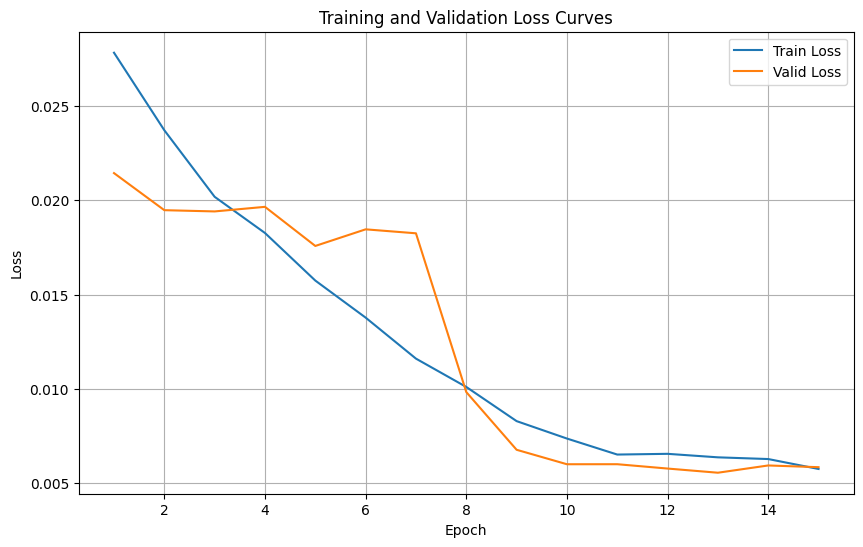

In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = CNNClassifier()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
# loss_function = nn.BCEWithLogitsLoss()
class_weights_train = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_np), y=train_labels_np)
class_weights_train_tensor = torch.tensor(class_weights_train, dtype=torch.float32).to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights_train_tensor[1])

# full_labels = np.array([int(dataset[i][1].item()) for i in range(len(dataset))])
# class_weights_sampler = compute_class_weight(class_weight='balanced', classes=np.unique(full_labels), y=full_labels)
# sample_weights = [class_weights_sampler[label] for label in full_labels]
# sample_weights = torch.tensor(sample_weights, dtype=torch.float32)
# full_dataset_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []
valid_auroc_all, valid_ap_all, valid_f1_all = [], [], [] # Lists to store metrics

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    # Compute AUROC, AP, and F1
    valid_auroc = roc_auc_score(y_true, y_pred)
    valid_ap = average_precision_score(y_true, y_pred)
    # For F1, we need binary predictions. A common threshold is 0.5 after sigmoid.
    valid_f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

    # Collect metrics
    valid_auroc_all.append(valid_auroc)
    valid_ap_all.append(valid_ap)
    valid_f1_all.append(valid_f1)

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'Valid AUROC {valid_auroc:.4f} \t'
                'Valid AP {valid_ap:.4f} \t'
                'Valid F1 {valid_f1:.4f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        valid_auroc=valid_auroc,
                        valid_ap=valid_ap,
                        valid_f1=valid_f1,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_all, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss_all, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


Fold 1/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.028373 	Valid Loss 0.017239 	Valid AUROC 0.7998 	Valid AP 0.6131 	Valid F1 0.5537 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023129 	Valid Loss 0.013167 	Valid AUROC 0.8689 	Valid AP 0.7358 	Valid F1 0.6113 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019081 	Valid Loss 0.011589 	Valid AUROC 0.9143 	Valid AP 0.8229 	Valid F1 0.6420 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.016158 	Valid Loss 0.010019 	Valid AUROC 0.9343 	Valid AP 0.8620 	Valid F1 0.7301 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.013234 	Valid Loss 0.008191 	Valid AUROC 0.9666 	Valid AP 0.9226 	Valid F1 0.7900 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.011122 	Valid Loss 0.006648 	Valid AUROC 0.9776 	Valid AP 0.9433 	Valid F1 0.8284 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.009946 	Valid Loss 0.005304 	Valid AUROC 0.9852 	Valid AP 0.9610 	Valid F1 0.8786 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.008184 	Valid Loss 0.004601 	Valid AUROC 0.9862 	Valid AP 0.9647 	Valid F1 0.9026 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.007671 	Valid Loss 0.003951 	Valid AUROC 0.9894 	Valid AP 0.9739 	Valid F1 0.9223 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.006486 	Valid Loss 0.003578 	Valid AUROC 0.9917 	Valid AP 0.9805 	Valid F1 0.9272 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.005935 	Valid Loss 0.003542 	Valid AUROC 0.9919 	Valid AP 0.9804 	Valid F1 0.9295 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.005860 	Valid Loss 0.003570 	Valid AUROC 0.9931 	Valid AP 0.9839 	Valid F1 0.9304 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.005639 	Valid Loss 0.003342 	Valid AUROC 0.9930 	Valid AP 0.9833 	Valid F1 0.9353 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.005414 	Valid Loss 0.003336 	Valid AUROC 0.9931 	Valid AP 0.9839 	Valid F1 0.9318 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005861 	Valid Loss 0.003260 	Valid AUROC 0.9936 	Valid AP 0.9852 	Valid F1 0.9331 	Best model for this fold -> saved


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

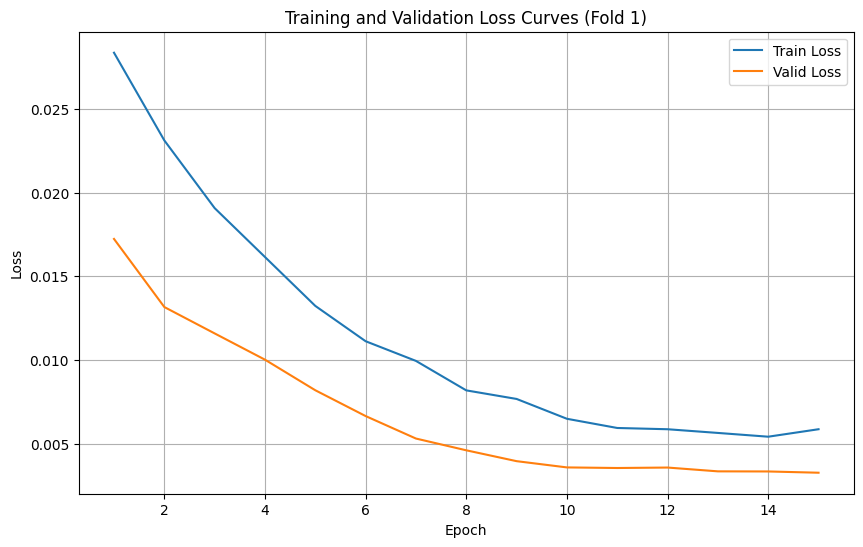

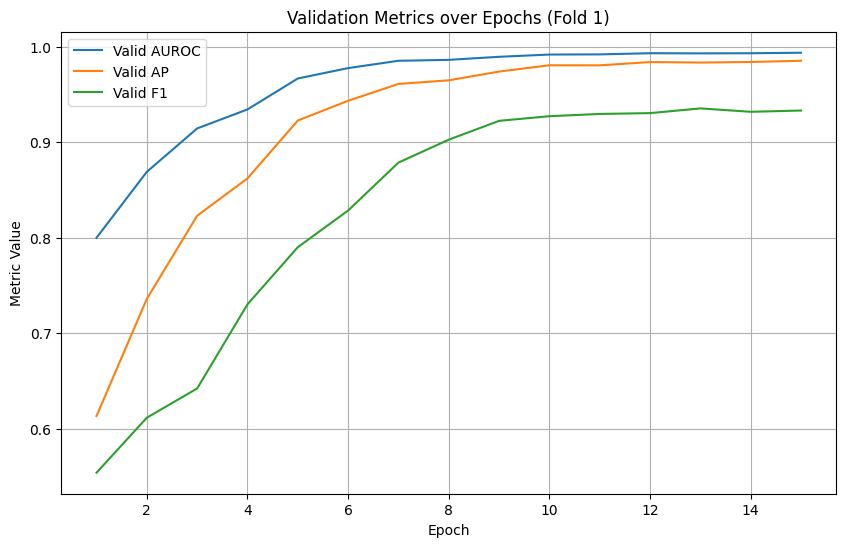


Fold 2/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.028610 	Valid Loss 0.016722 	Valid AUROC 0.7894 	Valid AP 0.5913 	Valid F1 0.4822 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023829 	Valid Loss 0.013986 	Valid AUROC 0.8603 	Valid AP 0.6967 	Valid F1 0.5177 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.020218 	Valid Loss 0.013355 	Valid AUROC 0.8969 	Valid AP 0.7734 	Valid F1 0.5309 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017928 	Valid Loss 0.013026 	Valid AUROC 0.9222 	Valid AP 0.8233 	Valid F1 0.5682 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015779 	Valid Loss 0.014066 	Valid AUROC 0.9401 	Valid AP 0.8641 	Valid F1 0.5390 	


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.013654 	Valid Loss 0.019735 	Valid AUROC 0.9527 	Valid AP 0.8819 	Valid F1 0.4762 	


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.011596 	Valid Loss 0.011436 	Valid AUROC 0.9707 	Valid AP 0.9236 	Valid F1 0.7104 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.010294 	Valid Loss 0.010893 	Valid AUROC 0.9791 	Valid AP 0.9446 	Valid F1 0.7009 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.008587 	Valid Loss 0.007620 	Valid AUROC 0.9817 	Valid AP 0.9479 	Valid F1 0.8251 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007184 	Valid Loss 0.007368 	Valid AUROC 0.9842 	Valid AP 0.9549 	Valid F1 0.8340 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006912 	Valid Loss 0.008902 	Valid AUROC 0.9844 	Valid AP 0.9549 	Valid F1 0.7922 	


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006543 	Valid Loss 0.006934 	Valid AUROC 0.9855 	Valid AP 0.9591 	Valid F1 0.8598 	Best model for this fold -> saved


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006337 	Valid Loss 0.006797 	Valid AUROC 0.9853 	Valid AP 0.9549 	Valid F1 0.8556 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006504 	Valid Loss 0.006644 	Valid AUROC 0.9863 	Valid AP 0.9609 	Valid F1 0.8661 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005990 	Valid Loss 0.008044 	Valid AUROC 0.9855 	Valid AP 0.9543 	Valid F1 0.8260 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

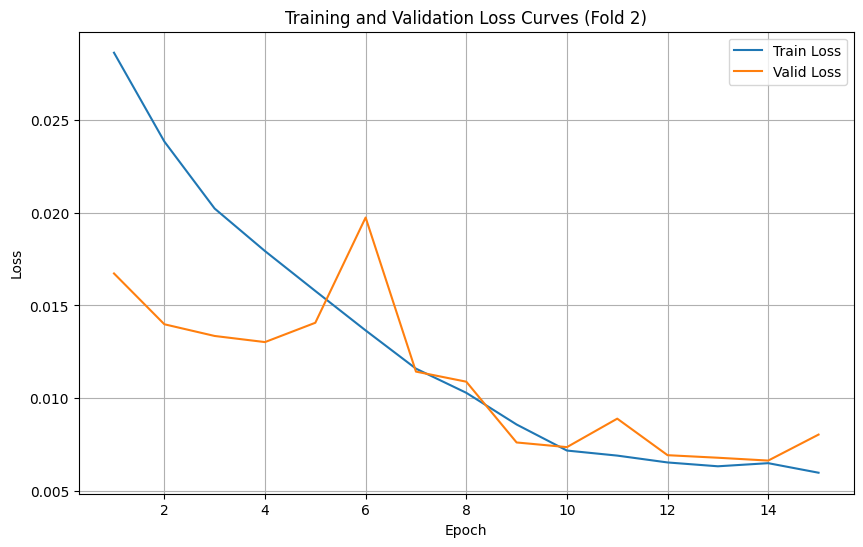

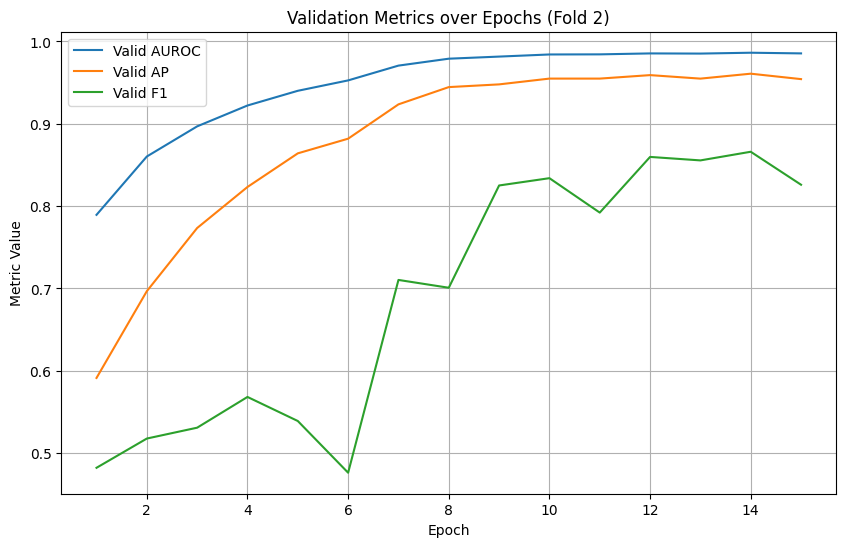


Fold 3/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027852 	Valid Loss 0.017080 	Valid AUROC 0.7836 	Valid AP 0.6170 	Valid F1 0.5139 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023140 	Valid Loss 0.014755 	Valid AUROC 0.8471 	Valid AP 0.7149 	Valid F1 0.5321 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019482 	Valid Loss 0.014422 	Valid AUROC 0.8899 	Valid AP 0.7789 	Valid F1 0.5024 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017535 	Valid Loss 0.014388 	Valid AUROC 0.9209 	Valid AP 0.8233 	Valid F1 0.5205 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.014710 	Valid Loss 0.014277 	Valid AUROC 0.9429 	Valid AP 0.8745 	Valid F1 0.5240 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.012695 	Valid Loss 0.012833 	Valid AUROC 0.9579 	Valid AP 0.9089 	Valid F1 0.6154 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.010467 	Valid Loss 0.009339 	Valid AUROC 0.9701 	Valid AP 0.9397 	Valid F1 0.7769 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.008742 	Valid Loss 0.008963 	Valid AUROC 0.9772 	Valid AP 0.9554 	Valid F1 0.8023 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.007818 	Valid Loss 0.005265 	Valid AUROC 0.9832 	Valid AP 0.9639 	Valid F1 0.9085 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.006798 	Valid Loss 0.004842 	Valid AUROC 0.9868 	Valid AP 0.9725 	Valid F1 0.9130 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.005647 	Valid Loss 0.005002 	Valid AUROC 0.9864 	Valid AP 0.9716 	Valid F1 0.9130 	


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.005938 	Valid Loss 0.004961 	Valid AUROC 0.9867 	Valid AP 0.9710 	Valid F1 0.9110 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.005618 	Valid Loss 0.004676 	Valid AUROC 0.9871 	Valid AP 0.9729 	Valid F1 0.9209 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.005441 	Valid Loss 0.004308 	Valid AUROC 0.9875 	Valid AP 0.9734 	Valid F1 0.9324 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005285 	Valid Loss 0.004794 	Valid AUROC 0.9867 	Valid AP 0.9708 	Valid F1 0.9187 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

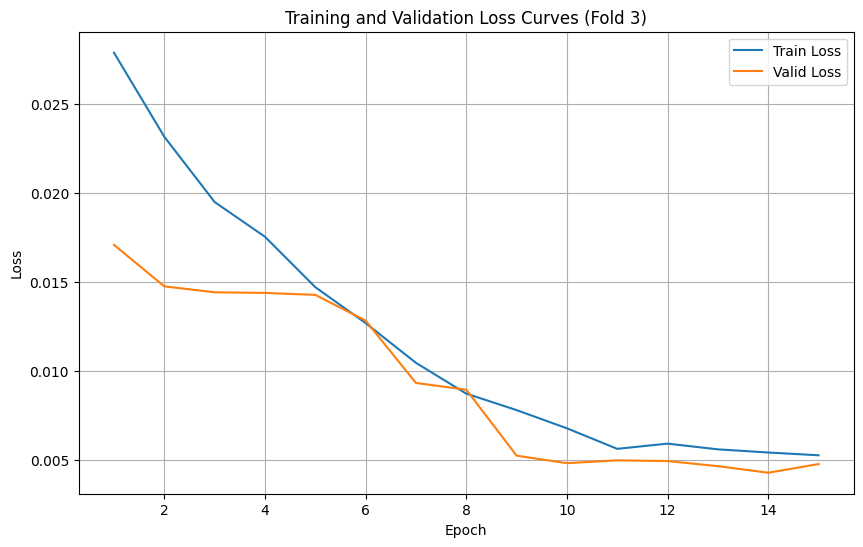

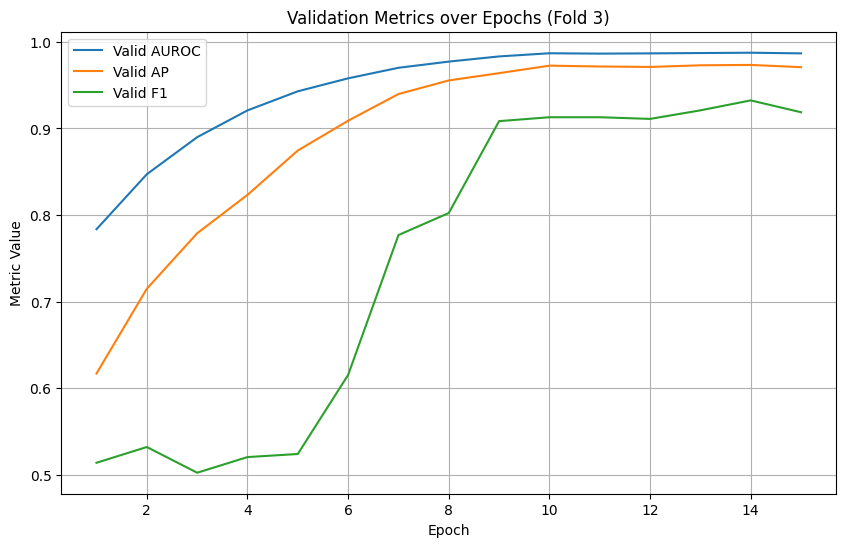


Fold 4/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.028305 	Valid Loss 0.018498 	Valid AUROC 0.7667 	Valid AP 0.5510 	Valid F1 0.5000 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023515 	Valid Loss 0.015445 	Valid AUROC 0.8128 	Valid AP 0.6234 	Valid F1 0.5594 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.020363 	Valid Loss 0.013928 	Valid AUROC 0.8515 	Valid AP 0.6971 	Valid F1 0.5848 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.018207 	Valid Loss 0.013226 	Valid AUROC 0.8845 	Valid AP 0.7626 	Valid F1 0.5937 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.016203 	Valid Loss 0.013478 	Valid AUROC 0.9108 	Valid AP 0.8170 	Valid F1 0.5969 	


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.014110 	Valid Loss 0.012046 	Valid AUROC 0.9392 	Valid AP 0.8715 	Valid F1 0.6391 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.012170 	Valid Loss 0.009093 	Valid AUROC 0.9530 	Valid AP 0.9054 	Valid F1 0.7572 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.009572 	Valid Loss 0.007944 	Valid AUROC 0.9664 	Valid AP 0.9327 	Valid F1 0.8296 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.008519 	Valid Loss 0.006375 	Valid AUROC 0.9749 	Valid AP 0.9466 	Valid F1 0.8628 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007285 	Valid Loss 0.006012 	Valid AUROC 0.9790 	Valid AP 0.9525 	Valid F1 0.8881 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006481 	Valid Loss 0.006596 	Valid AUROC 0.9794 	Valid AP 0.9524 	Valid F1 0.8700 	


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006596 	Valid Loss 0.006353 	Valid AUROC 0.9804 	Valid AP 0.9538 	Valid F1 0.8849 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006433 	Valid Loss 0.006284 	Valid AUROC 0.9797 	Valid AP 0.9536 	Valid F1 0.8788 	


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006265 	Valid Loss 0.005835 	Valid AUROC 0.9798 	Valid AP 0.9532 	Valid F1 0.8889 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.006088 	Valid Loss 0.005621 	Valid AUROC 0.9807 	Valid AP 0.9528 	Valid F1 0.8889 	Best model for this fold -> saved


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

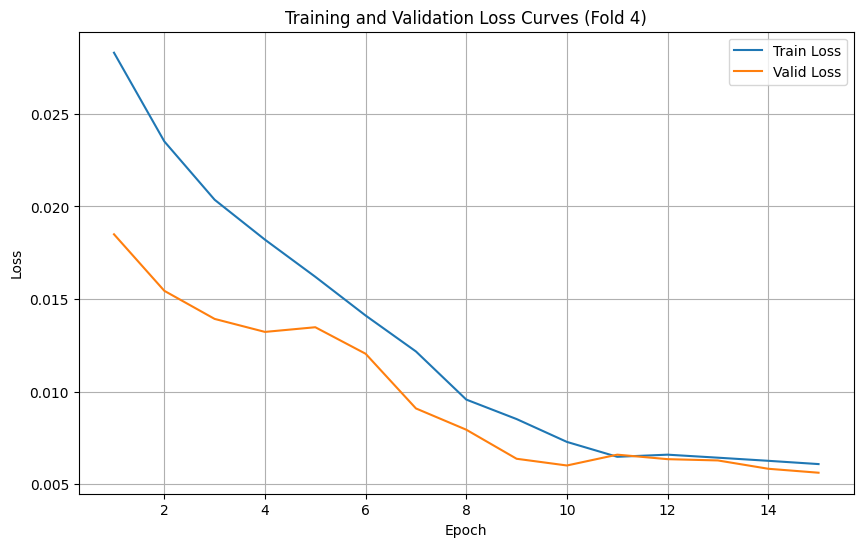

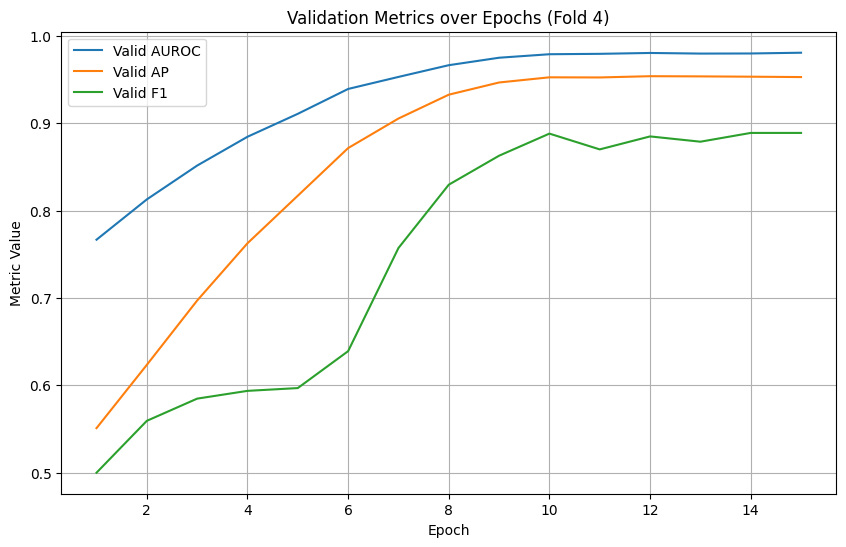


Fold 5/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027889 	Valid Loss 0.017299 	Valid AUROC 0.7852 	Valid AP 0.6031 	Valid F1 0.3591 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.024673 	Valid Loss 0.015360 	Valid AUROC 0.8477 	Valid AP 0.6985 	Valid F1 0.3836 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.020388 	Valid Loss 0.015498 	Valid AUROC 0.8912 	Valid AP 0.7801 	Valid F1 0.3874 	


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.018779 	Valid Loss 0.014699 	Valid AUROC 0.9187 	Valid AP 0.8252 	Valid F1 0.4802 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.016017 	Valid Loss 0.013511 	Valid AUROC 0.9305 	Valid AP 0.8507 	Valid F1 0.5240 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.014325 	Valid Loss 0.011024 	Valid AUROC 0.9522 	Valid AP 0.9007 	Valid F1 0.6866 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.012440 	Valid Loss 0.009611 	Valid AUROC 0.9573 	Valid AP 0.9127 	Valid F1 0.7445 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.010413 	Valid Loss 0.007078 	Valid AUROC 0.9778 	Valid AP 0.9457 	Valid F1 0.8249 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.009076 	Valid Loss 0.005815 	Valid AUROC 0.9842 	Valid AP 0.9547 	Valid F1 0.8582 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007649 	Valid Loss 0.004234 	Valid AUROC 0.9864 	Valid AP 0.9575 	Valid F1 0.9192 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006878 	Valid Loss 0.004062 	Valid AUROC 0.9877 	Valid AP 0.9615 	Valid F1 0.9231 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006393 	Valid Loss 0.004785 	Valid AUROC 0.9891 	Valid AP 0.9641 	Valid F1 0.8925 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006128 	Valid Loss 0.004023 	Valid AUROC 0.9887 	Valid AP 0.9647 	Valid F1 0.9294 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006449 	Valid Loss 0.004019 	Valid AUROC 0.9897 	Valid AP 0.9653 	Valid F1 0.9233 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.006139 	Valid Loss 0.003998 	Valid AUROC 0.9893 	Valid AP 0.9670 	Valid F1 0.9239 	Best model for this fold -> saved


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

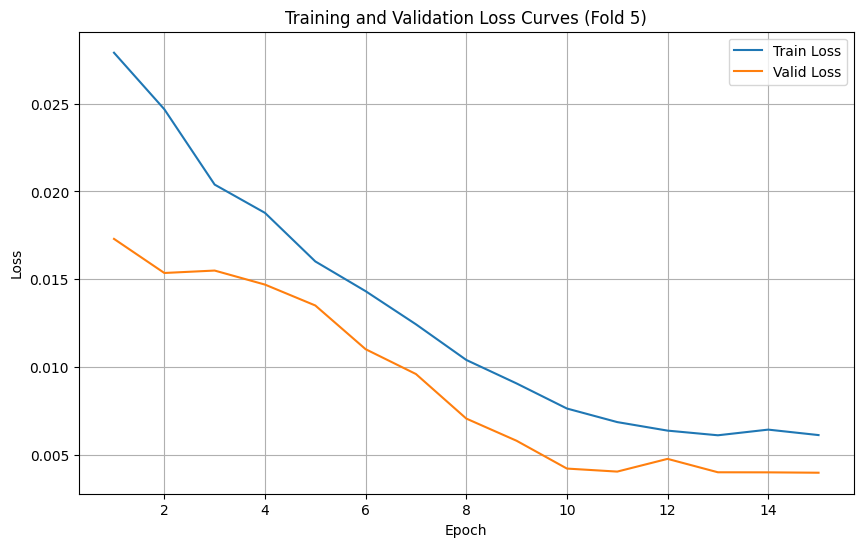

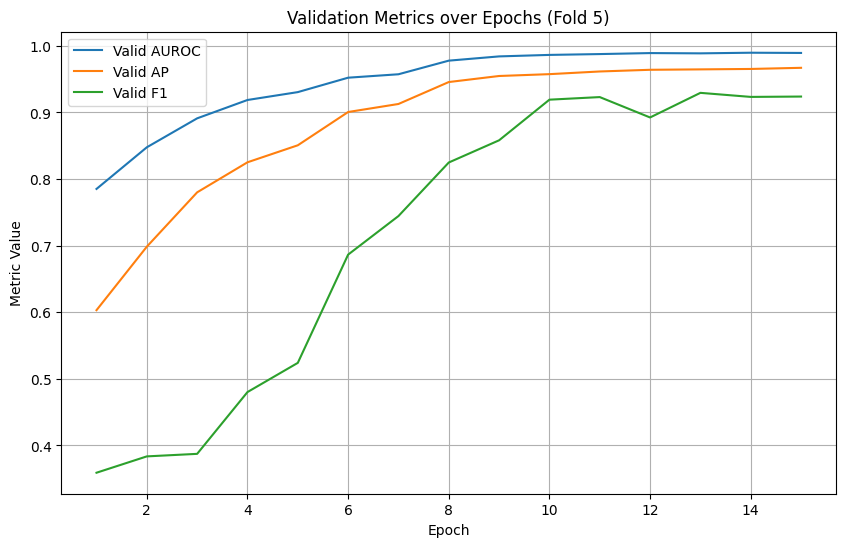


Fold 6/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.028133 	Valid Loss 0.017729 	Valid AUROC 0.7767 	Valid AP 0.5757 	Valid F1 0.4249 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023249 	Valid Loss 0.016236 	Valid AUROC 0.8631 	Valid AP 0.7067 	Valid F1 0.3395 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019762 	Valid Loss 0.017243 	Valid AUROC 0.8936 	Valid AP 0.7673 	Valid F1 0.3351 	


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017833 	Valid Loss 0.018935 	Valid AUROC 0.9101 	Valid AP 0.8032 	Valid F1 0.3120 	


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.016366 	Valid Loss 0.019576 	Valid AUROC 0.9278 	Valid AP 0.8288 	Valid F1 0.3714 	


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.015021 	Valid Loss 0.017841 	Valid AUROC 0.9472 	Valid AP 0.8628 	Valid F1 0.4052 	


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.012748 	Valid Loss 0.015162 	Valid AUROC 0.9676 	Valid AP 0.9093 	Valid F1 0.5394 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.010815 	Valid Loss 0.011070 	Valid AUROC 0.9744 	Valid AP 0.9244 	Valid F1 0.6767 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.009153 	Valid Loss 0.007907 	Valid AUROC 0.9846 	Valid AP 0.9590 	Valid F1 0.8000 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007754 	Valid Loss 0.005019 	Valid AUROC 0.9886 	Valid AP 0.9679 	Valid F1 0.8837 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006798 	Valid Loss 0.004920 	Valid AUROC 0.9885 	Valid AP 0.9656 	Valid F1 0.8901 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006742 	Valid Loss 0.005210 	Valid AUROC 0.9892 	Valid AP 0.9695 	Valid F1 0.8925 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006265 	Valid Loss 0.005057 	Valid AUROC 0.9903 	Valid AP 0.9716 	Valid F1 0.8989 	


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006345 	Valid Loss 0.004546 	Valid AUROC 0.9896 	Valid AP 0.9704 	Valid F1 0.9135 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.006308 	Valid Loss 0.004919 	Valid AUROC 0.9903 	Valid AP 0.9708 	Valid F1 0.9036 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

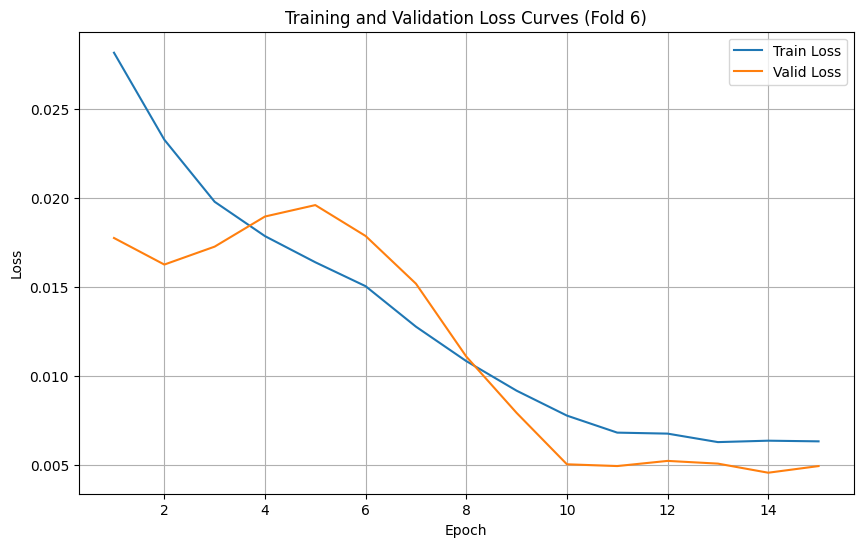

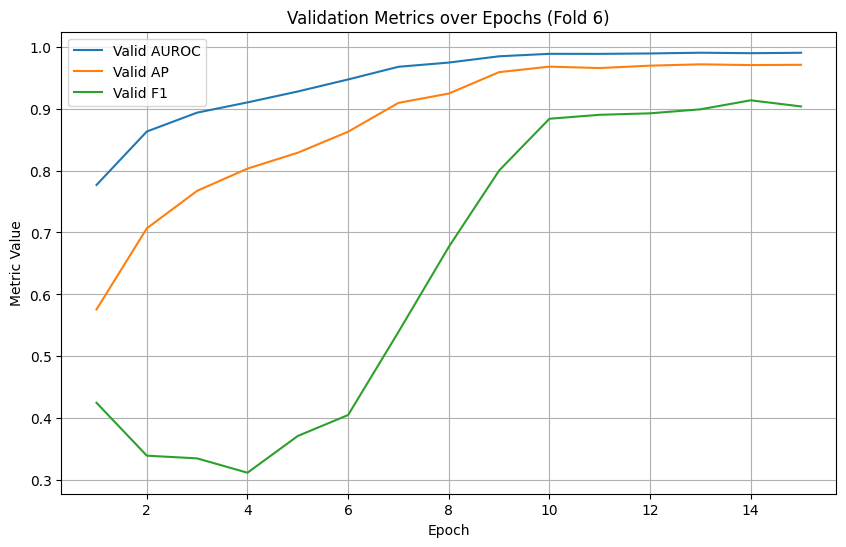


Fold 7/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027872 	Valid Loss 0.016671 	Valid AUROC 0.8341 	Valid AP 0.6704 	Valid F1 0.3910 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023550 	Valid Loss 0.013781 	Valid AUROC 0.8867 	Valid AP 0.7948 	Valid F1 0.4688 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019902 	Valid Loss 0.014906 	Valid AUROC 0.9190 	Valid AP 0.8470 	Valid F1 0.4467 	


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017743 	Valid Loss 0.016530 	Valid AUROC 0.9252 	Valid AP 0.8559 	Valid F1 0.3958 	


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015819 	Valid Loss 0.018035 	Valid AUROC 0.9431 	Valid AP 0.8815 	Valid F1 0.4219 	


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.015106 	Valid Loss 0.016347 	Valid AUROC 0.9560 	Valid AP 0.9060 	Valid F1 0.4747 	


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.012383 	Valid Loss 0.014579 	Valid AUROC 0.9683 	Valid AP 0.9294 	Valid F1 0.5921 	


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.011017 	Valid Loss 0.010196 	Valid AUROC 0.9806 	Valid AP 0.9533 	Valid F1 0.6994 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.009028 	Valid Loss 0.012404 	Valid AUROC 0.9825 	Valid AP 0.9558 	Valid F1 0.6652 	


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007947 	Valid Loss 0.009711 	Valid AUROC 0.9875 	Valid AP 0.9670 	Valid F1 0.7076 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006929 	Valid Loss 0.007670 	Valid AUROC 0.9905 	Valid AP 0.9753 	Valid F1 0.7726 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006713 	Valid Loss 0.008465 	Valid AUROC 0.9897 	Valid AP 0.9737 	Valid F1 0.7360 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.006943 	Valid Loss 0.005309 	Valid AUROC 0.9916 	Valid AP 0.9779 	Valid F1 0.8646 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006594 	Valid Loss 0.007385 	Valid AUROC 0.9904 	Valid AP 0.9750 	Valid F1 0.7809 	


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.006286 	Valid Loss 0.006230 	Valid AUROC 0.9911 	Valid AP 0.9773 	Valid F1 0.8253 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

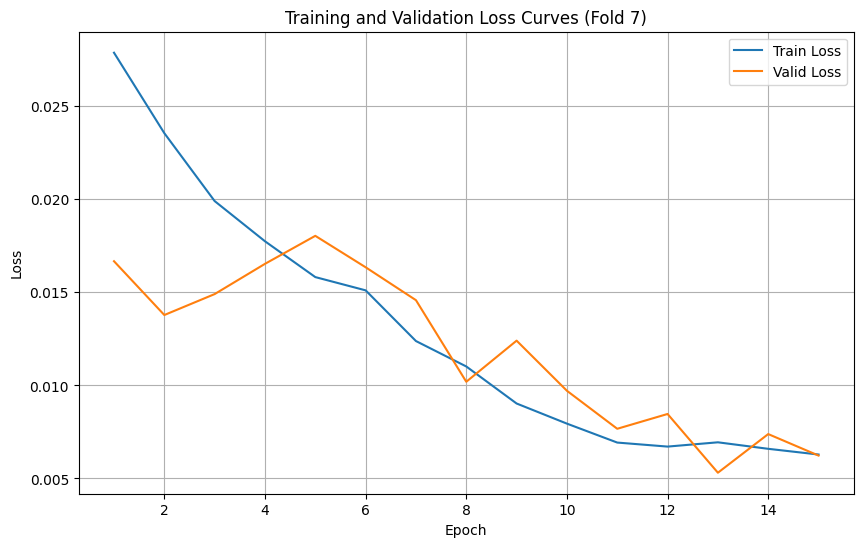

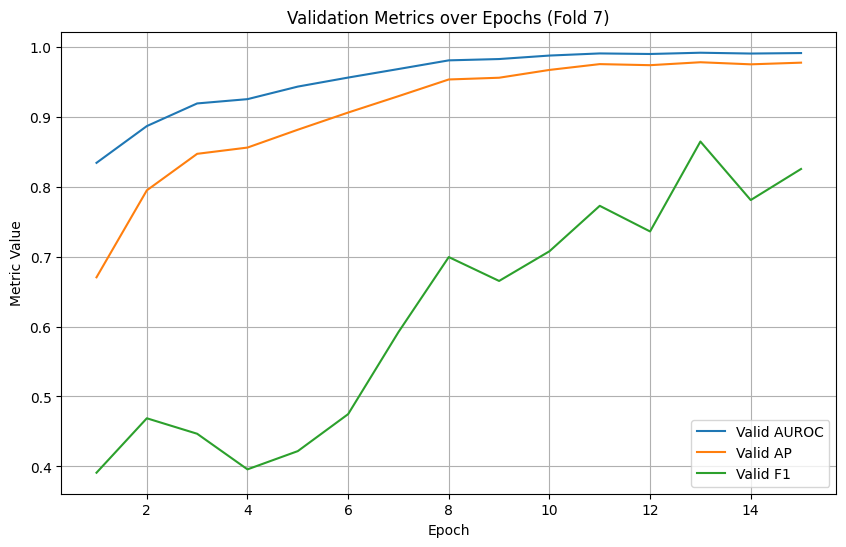


Fold 8/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027528 	Valid Loss 0.015639 	Valid AUROC 0.8209 	Valid AP 0.6681 	Valid F1 0.4898 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.022193 	Valid Loss 0.015698 	Valid AUROC 0.8707 	Valid AP 0.7536 	Valid F1 0.3969 	


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019495 	Valid Loss 0.014669 	Valid AUROC 0.8971 	Valid AP 0.8002 	Valid F1 0.4916 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017456 	Valid Loss 0.013420 	Valid AUROC 0.9019 	Valid AP 0.8175 	Valid F1 0.5650 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015414 	Valid Loss 0.012963 	Valid AUROC 0.9448 	Valid AP 0.8862 	Valid F1 0.5727 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.012798 	Valid Loss 0.011394 	Valid AUROC 0.9613 	Valid AP 0.9125 	Valid F1 0.6808 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.010955 	Valid Loss 0.010865 	Valid AUROC 0.9725 	Valid AP 0.9383 	Valid F1 0.7164 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.008941 	Valid Loss 0.009881 	Valid AUROC 0.9784 	Valid AP 0.9487 	Valid F1 0.7454 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.008041 	Valid Loss 0.006848 	Valid AUROC 0.9840 	Valid AP 0.9611 	Valid F1 0.8577 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.007114 	Valid Loss 0.005479 	Valid AUROC 0.9864 	Valid AP 0.9660 	Valid F1 0.9059 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006397 	Valid Loss 0.005045 	Valid AUROC 0.9883 	Valid AP 0.9706 	Valid F1 0.9151 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006139 	Valid Loss 0.006018 	Valid AUROC 0.9881 	Valid AP 0.9705 	Valid F1 0.8881 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.005972 	Valid Loss 0.004974 	Valid AUROC 0.9889 	Valid AP 0.9728 	Valid F1 0.9180 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.006261 	Valid Loss 0.004858 	Valid AUROC 0.9883 	Valid AP 0.9726 	Valid F1 0.9180 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005876 	Valid Loss 0.004481 	Valid AUROC 0.9904 	Valid AP 0.9773 	Valid F1 0.9289 	Best model for this fold -> saved


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

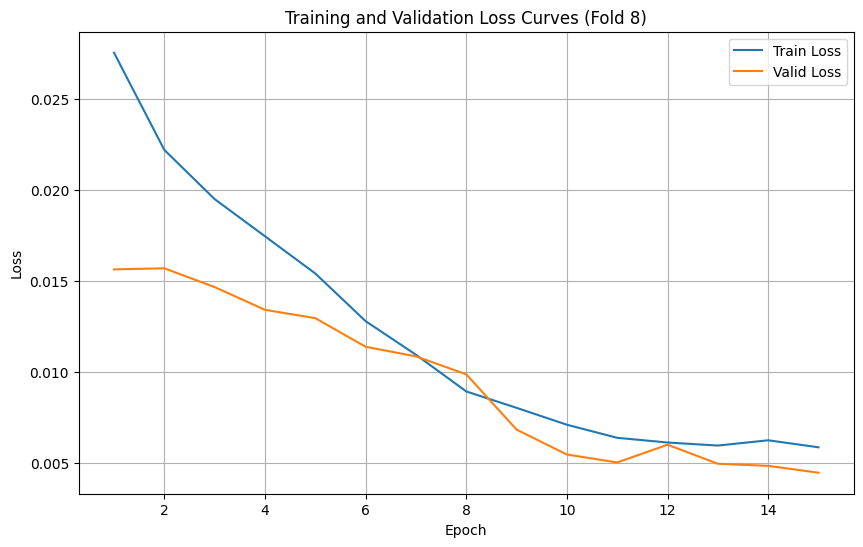

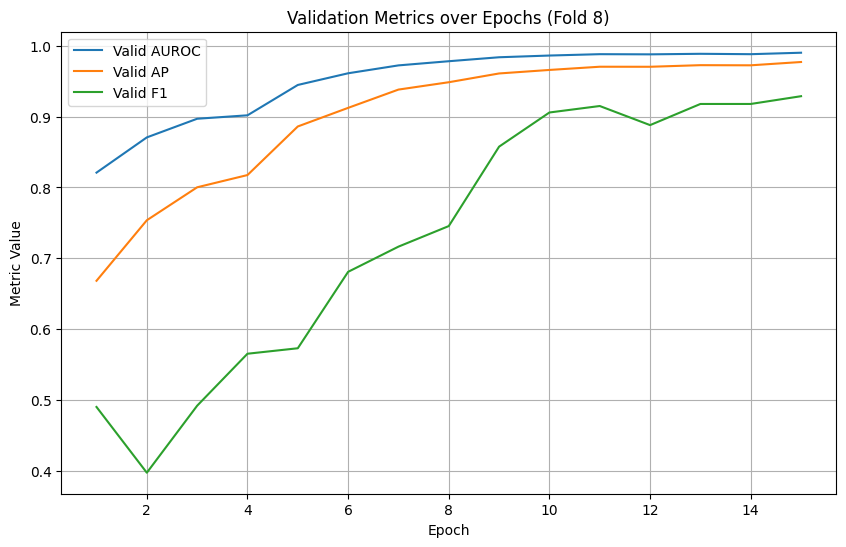


Fold 9/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.028230 	Valid Loss 0.018007 	Valid AUROC 0.7523 	Valid AP 0.5792 	Valid F1 0.5413 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.023886 	Valid Loss 0.015011 	Valid AUROC 0.8184 	Valid AP 0.6562 	Valid F1 0.5368 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019825 	Valid Loss 0.012978 	Valid AUROC 0.8917 	Valid AP 0.7853 	Valid F1 0.5618 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.018090 	Valid Loss 0.014161 	Valid AUROC 0.9149 	Valid AP 0.8322 	Valid F1 0.4776 	


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015923 	Valid Loss 0.015043 	Valid AUROC 0.9349 	Valid AP 0.8677 	Valid F1 0.4596 	


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.013914 	Valid Loss 0.014285 	Valid AUROC 0.9576 	Valid AP 0.8985 	Valid F1 0.5324 	


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.011568 	Valid Loss 0.011541 	Valid AUROC 0.9717 	Valid AP 0.9327 	Valid F1 0.6520 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.009018 	Valid Loss 0.007907 	Valid AUROC 0.9784 	Valid AP 0.9539 	Valid F1 0.7922 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.007838 	Valid Loss 0.006360 	Valid AUROC 0.9830 	Valid AP 0.9618 	Valid F1 0.8242 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.006721 	Valid Loss 0.005839 	Valid AUROC 0.9853 	Valid AP 0.9619 	Valid F1 0.8556 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006097 	Valid Loss 0.005540 	Valid AUROC 0.9870 	Valid AP 0.9694 	Valid F1 0.8603 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006079 	Valid Loss 0.005076 	Valid AUROC 0.9871 	Valid AP 0.9690 	Valid F1 0.8813 	Best model for this fold -> saved


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.005902 	Valid Loss 0.005928 	Valid AUROC 0.9867 	Valid AP 0.9688 	Valid F1 0.8513 	


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.005755 	Valid Loss 0.005322 	Valid AUROC 0.9868 	Valid AP 0.9697 	Valid F1 0.8743 	


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.005671 	Valid Loss 0.005165 	Valid AUROC 0.9876 	Valid AP 0.9711 	Valid F1 0.8804 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

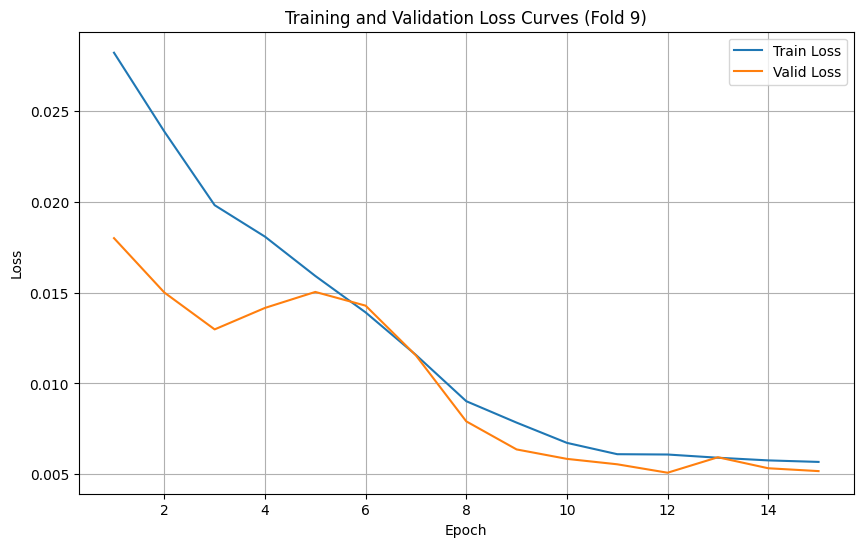

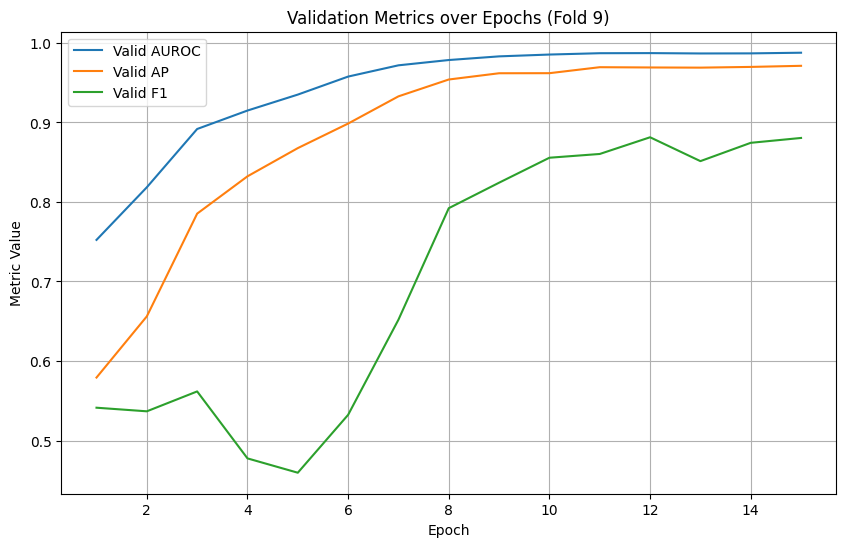


Fold 10/10


  0%|          | 0/15 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.027316 	Valid Loss 0.016866 	Valid AUROC 0.8050 	Valid AP 0.6195 	Valid F1 0.4675 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.022796 	Valid Loss 0.013709 	Valid AUROC 0.8631 	Valid AP 0.7248 	Valid F1 0.5961 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.019807 	Valid Loss 0.012852 	Valid AUROC 0.8944 	Valid AP 0.7630 	Valid F1 0.5823 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.017462 	Valid Loss 0.011376 	Valid AUROC 0.9262 	Valid AP 0.8381 	Valid F1 0.6387 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.015367 	Valid Loss 0.010265 	Valid AUROC 0.9434 	Valid AP 0.8660 	Valid F1 0.7024 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.013060 	Valid Loss 0.008668 	Valid AUROC 0.9625 	Valid AP 0.9079 	Valid F1 0.7639 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.011524 	Valid Loss 0.007260 	Valid AUROC 0.9728 	Valid AP 0.9338 	Valid F1 0.8372 	Best model for this fold -> saved


Training Epoch  8:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.009359 	Valid Loss 0.006577 	Valid AUROC 0.9810 	Valid AP 0.9518 	Valid F1 0.8638 	Best model for this fold -> saved


Training Epoch  9:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.008077 	Valid Loss 0.005841 	Valid AUROC 0.9847 	Valid AP 0.9589 	Valid F1 0.8613 	Best model for this fold -> saved


Training Epoch 10:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.006837 	Valid Loss 0.004970 	Valid AUROC 0.9874 	Valid AP 0.9682 	Valid F1 0.8947 	Best model for this fold -> saved


Training Epoch 11:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.006279 	Valid Loss 0.004543 	Valid AUROC 0.9882 	Valid AP 0.9709 	Valid F1 0.9103 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.006193 	Valid Loss 0.004648 	Valid AUROC 0.9880 	Valid AP 0.9707 	Valid F1 0.9085 	


Training Epoch 13:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.005773 	Valid Loss 0.004563 	Valid AUROC 0.9882 	Valid AP 0.9697 	Valid F1 0.9116 	


Training Epoch 14:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.005686 	Valid Loss 0.004314 	Valid AUROC 0.9894 	Valid AP 0.9745 	Valid F1 0.9157 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/282 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.006106 	Valid Loss 0.004422 	Valid AUROC 0.9887 	Valid AP 0.9715 	Valid F1 0.9277 	


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

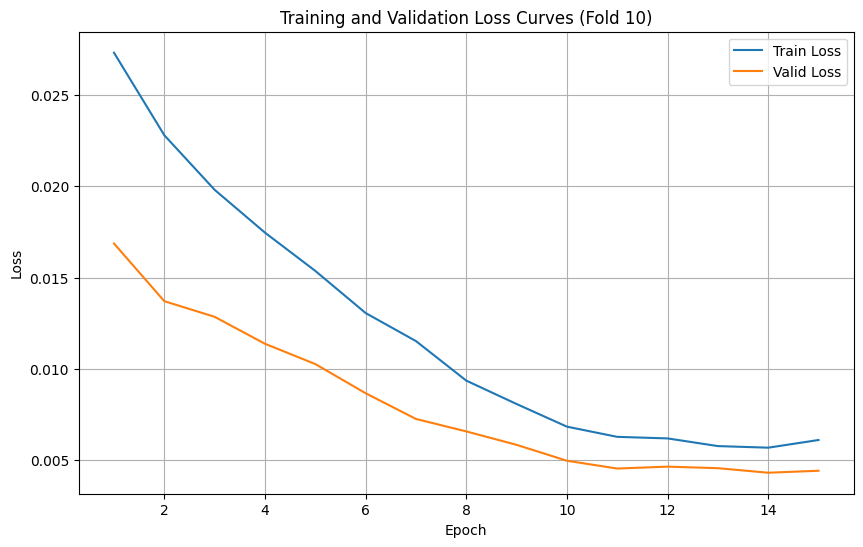

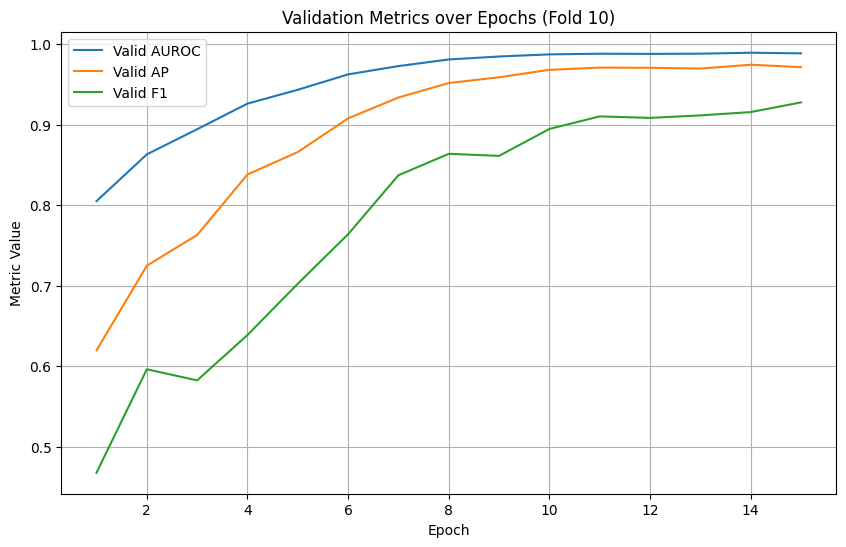

In [30]:
#added for stratified k-fold crossvalidation
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR

# Define the number of folds
k_folds = 10

# Initialize StratifiedKFold
# We use labels.numpy().ravel() to get a 1D array of labels for stratification
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

# Lists to store metrics for each fold
fold_auroc_all, fold_ap_all, fold_f1_all = [], [], []

# Iterate through the folds
for fold, (train_idx, valid_idx) in enumerate(skf.split(dataset, labels.numpy().ravel())):
    tqdm.write(f"\nFold {fold+1}/{k_folds}")

    # Get the subsets for the current fold
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    valid_subset = torch.utils.data.Subset(dataset, valid_idx)

    # Calculate class weights for the current training subset for oversampling
    train_labels_fold = np.array([int(train_subset[i][1].item()) for i in range(len(train_subset))])
    class_weights_sampler_fold = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_fold), y=train_labels_fold)
    sample_weights_fold = [class_weights_sampler_fold[label] for label in train_labels_fold]
    sample_weights_fold = torch.tensor(sample_weights_fold, dtype=torch.float32)
    sampler_fold = WeightedRandomSampler(weights=sample_weights_fold, num_samples=len(sample_weights_fold), replacement=True)

    # Create DataLoaders for the current fold
    train_dataloader_fold = DataLoader(train_subset, batch_size=batch_size, sampler=sampler_fold)
    valid_dataloader_fold = DataLoader(valid_subset, batch_size=batch_size, shuffle=False) # No sampler for validation

    # Initialize a new model, optimizer, and scheduler for each fold
    model = CNNClassifier()
    model.to(device=device)
    # Ensure class_weights_sampler_fold is used for weighted loss for the current fold
    loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights_sampler_fold[1], dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    best_loss_fold = np.Inf
    train_loss_all_fold, valid_loss_all_fold = [], []
    valid_auroc_all_fold, valid_ap_all_fold, valid_f1_all_fold = [], [], []

    # Training and evaluation loop for the current fold
    for epoch in trange(1, num_epochs + 1):
        train_loss = train_loop(epoch, train_dataloader_fold, model, optimizer, loss_function, device)
        valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader_fold, model, nn.BCEWithLogitsLoss(), device) # Use standard loss for validation

        train_loss_all_fold.append(train_loss)
        valid_loss_all_fold.append(valid_loss)

        valid_auroc = roc_auc_score(y_true, y_pred)
        valid_ap = average_precision_score(y_true, y_pred)
        valid_f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

        valid_auroc_all_fold.append(valid_auroc)
        valid_ap_all_fold.append(valid_ap)
        valid_f1_all_fold.append(valid_f1)


        if valid_loss < best_loss_fold:
            # Optionally save the best model for this fold
            torch.save({'model': model.state_dict()}, f'model_fold_{fold+1}.pth')
            best_loss_fold = valid_loss
            model_save_state = "Best model for this fold -> saved"
        else:
            model_save_state = ""

        tqdm.write('Epoch {epoch:2d}: \t'
                    'Train Loss {train_loss:.6f} \t'
                    'Valid Loss {valid_loss:.6f} \t'
                    'Valid AUROC {valid_auroc:.4f} \t'
                    'Valid AP {valid_ap:.4f} \t'
                    'Valid F1 {valid_f1:.4f} \t'
                    '{model_save}'
                    .format(epoch=epoch,
                            train_loss=train_loss,
                            valid_loss=valid_loss,
                            valid_auroc=valid_auroc,
                            valid_ap=valid_ap,
                            valid_f1=valid_f1,
                            model_save=model_save_state)
                        )

        if lr_scheduler:
            lr_scheduler.step()

    # Store the best metrics from this fold
    best_epoch_idx = np.argmin(valid_loss_all_fold)
    fold_auroc_all.append(valid_auroc_all_fold[best_epoch_idx])
    fold_ap_all.append(valid_ap_all_fold[best_epoch_idx])
    fold_f1_all.append(valid_f1_all_fold[best_epoch_idx])

    # Plot learning curves for the current fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_loss_all_fold, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_loss_all_fold, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation metrics for the current fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), valid_auroc_all_fold, label='Valid AUROC')
    plt.plot(range(1, num_epochs + 1), valid_ap_all_fold, label='Valid AP')
    plt.plot(range(1, num_epochs + 1), valid_f1_all_fold, label='Valid F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(f'Validation Metrics over Epochs (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
# Examine the stored metrics for each fold
print("Performance metrics for each fold:")
for i, (auroc, ap, f1) in enumerate(zip(fold_auroc_all, fold_ap_all, fold_f1_all)):
    print(f"Fold {i+1}: AUROC={auroc:.4f}, AP={ap:.4f}, F1={f1:.4f}")

# Find the index of the best performing fold based on F1 score
best_fold_index = np.argmax(fold_f1_all)
best_f1_score = fold_f1_all[best_fold_index]
best_auroc_score = fold_auroc_all[best_fold_index]
best_ap_score = fold_ap_all[best_fold_index]

print(f"\nBest performing fold based on F1 score: Fold {best_fold_index + 1}")
print(f"Best F1 Score: {best_f1_score:.4f}")
print(f"Corresponding AUROC: {best_auroc_score:.4f}")
print(f"Corresponding AP: {best_ap_score:.4f}")

Performance metrics for each fold:
Fold 1: AUROC=0.9936, AP=0.9852, F1=0.9331
Fold 2: AUROC=0.9863, AP=0.9609, F1=0.8661
Fold 3: AUROC=0.9875, AP=0.9734, F1=0.9324
Fold 4: AUROC=0.9807, AP=0.9528, F1=0.8889
Fold 5: AUROC=0.9893, AP=0.9670, F1=0.9239
Fold 6: AUROC=0.9896, AP=0.9704, F1=0.9135
Fold 7: AUROC=0.9916, AP=0.9779, F1=0.8646
Fold 8: AUROC=0.9904, AP=0.9773, F1=0.9289
Fold 9: AUROC=0.9871, AP=0.9690, F1=0.8813
Fold 10: AUROC=0.9894, AP=0.9745, F1=0.9157

Best performing fold based on F1 score: Fold 1
Best F1 Score: 0.9331
Corresponding AUROC: 0.9936
Corresponding AP: 0.9852


---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [32]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [33]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
# model = ModelBaseline()
model = CNNClassifier()

# load stored model parameters from the best performing fold (Fold 5)
# The best fold index is stored in `best_fold_index` from the previous cell
ckpt = torch.load(f'model_fold_{best_fold_index + 1}.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [34]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [35]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'LundBooster' #Fill in a string
password = 'LundBooster' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [39]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Classifier-Comeback' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission updated!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**